<a href="https://colab.research.google.com/github/tdiggelm/nn-experiments/blob/master/attention_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import layers, models
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

Using TensorFlow backend.


In [0]:
n_samples = 5000
numbers = np.random.normal(0, 1, (n_samples, 3))
totals = np.sum(numbers, axis=1)
labels = np.array(totals > 0, dtype='int32')
noise = np.random.normal(0, 1, (n_samples, 10))
data = np.concatenate([numbers, noise], axis=1)
index = np.arange(data.shape[1])
np.random.shuffle(index)
rev_index = np.zeros_like(index)
for i, pos in enumerate(index):
  rev_index[pos] = i
data = data[:, index]

X_train, X_test, y_train, y_test = train_test_split(data, labels,
                                                    shuffle=False)

In [3]:
USE_ATTENTION = True
inputs = layers.Input(shape=(data.shape[1],))
x = inputs
if USE_ATTENTION:
  attention_dense = layers.Dense(1024)(inputs)
  attention_dense = layers.Activation('relu')(attention_dense)
  attention_dense = layers.Dropout(0.5)(attention_dense)
  attention_probs = layers.Dense(data.shape[1], activation='softmax',
                                 name='attention_probs')(attention_dense)
  x = layers.Multiply()([inputs, attention_probs])
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs, x)
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 13)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         14336       input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 1024)         0           dense_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1024)         0           activation_1[0][0]               
__________________________________________________________________________________________________
attention_

In [4]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=18, verbose=1, shuffle=True)

Train on 3750 samples, validate on 1250 samples
Epoch 1/18
3750/3750 [==============================] - 2s 462us/step - loss: 0.3495 - acc: 0.8864 - val_loss: 0.1260 - val_acc: 0.9672
Epoch 2/18
3750/3750 [==============================] - 1s 199us/step - loss: 0.1231 - acc: 0.9600 - val_loss: 0.0875 - val_acc: 0.9736
Epoch 3/18
3750/3750 [==============================] - 1s 207us/step - loss: 0.1065 - acc: 0.9624 - val_loss: 0.1260 - val_acc: 0.9520
Epoch 4/18
3750/3750 [==============================] - 1s 209us/step - loss: 0.0944 - acc: 0.9643 - val_loss: 0.0921 - val_acc: 0.9608
Epoch 5/18
3750/3750 [==============================] - 1s 204us/step - loss: 0.0831 - acc: 0.9715 - val_loss: 0.1018 - val_acc: 0.9600
Epoch 6/18
3750/3750 [==============================] - 1s 200us/step - loss: 0.0856 - acc: 0.9693 - val_loss: 0.0707 - val_acc: 0.9744
Epoch 7/18
3750/3750 [==============================] - 1s 203us/step - loss: 0.0743 - acc: 0.9736 - val_loss: 0.0671 - val_acc: 0.9752


Text(0.5, 0, 'epoch')

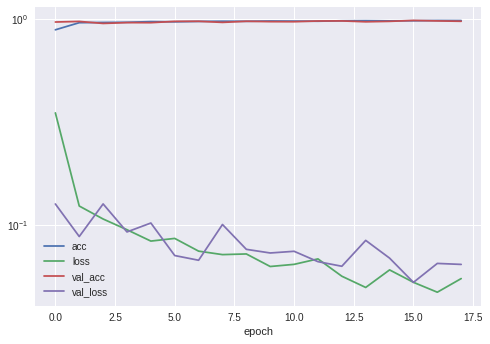

In [5]:
ax = pd.DataFrame(history.history).plot(logy=True)
ax.set_xlabel("epoch")

relevant numbers for classification in columns: 4, 8, 6


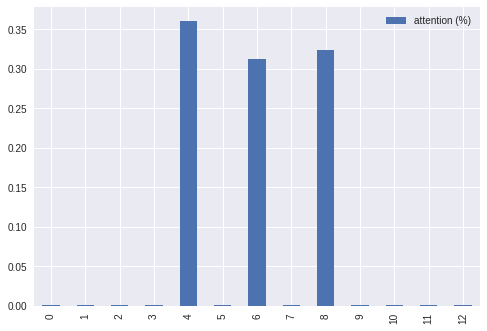

In [6]:
model_activations = models.Model(inputs, attention_probs)
activations = model_activations.predict(X_test).mean(axis=0)
pd.DataFrame(activations, columns=['attention (%)']).plot(kind='bar')

print('relevant numbers for classification in columns: %s' % 
        ', '.join(str(i) for i in rev_index[:3]))